[*********************100%***********************]  1 of 1 completed
c:\Genai\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 0.0243
Epoch 2/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 0.0018
Epoch 3/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0016
Epoch 4/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 0.0015
Epoch 5/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0014
Epoch 6/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0012
Epoch 7/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0012
Epoch 8/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0012
Epoch 9/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0011
Epoch 10/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0013
Epoch 11/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0010
Epoch 12/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0011
Epoch 13/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - loss: 9.8629e-04
Epoch 14/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 8.7234e-04
Epoch 15/25
98/98 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.

[*********************100%***********************]  1 of 1 completed


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step


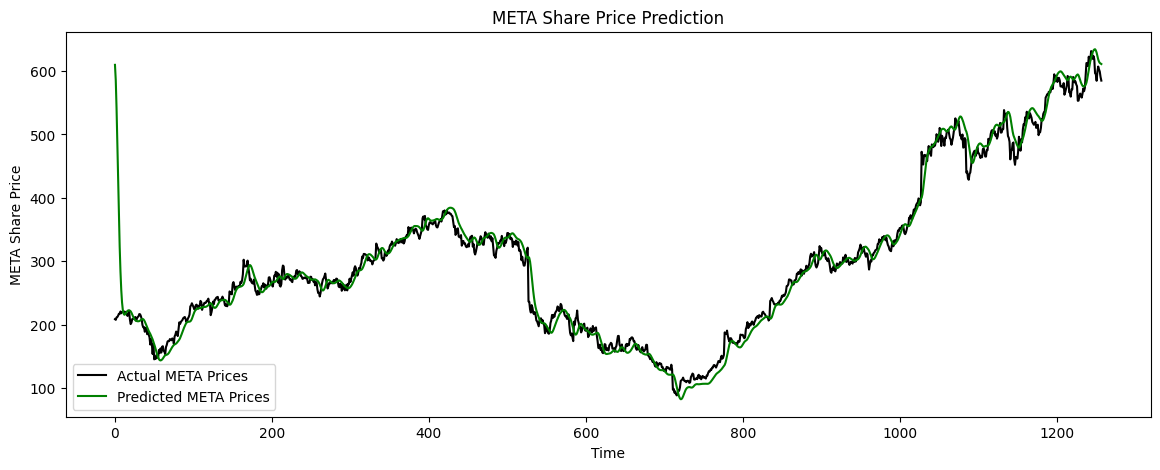

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
Predicted next day closing price: $609.86


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

# Set the ticker symbol
company = 'META'
start = dt.datetime(2012, 1, 1)
end = dt.datetime(2025, 1, 1)

# Download historical data
data = yf.download(company, start=start, end=end)

# Prepare data for training
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

prediction_days = 60
x_train, y_train = [], []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x-prediction_days:x, 0])
    y_train.append(scaled_data[x, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

# Build the LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=1)
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=25, batch_size=32)

# Load test data (2020 - 2025)
test_start = dt.datetime(2020, 1, 1)
test_end = dt.datetime(2025, 1, 1)
test_data = yf.download(company, start=test_start, end=test_end)
actual_prices = test_data['Close'].values

total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

# Prepare test inputs for prediction
x_test = []
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Predict prices
predicted_prices = model.predict(x_test)
predicted_prices = scaler.inverse_transform(predicted_prices)

# Plot results
plt.figure(figsize=(14, 5))
plt.plot(actual_prices, color='black', label=f'Actual {company} Prices')
plt.plot(predicted_prices, color='green', label=f'Predicted {company} Prices')
plt.title(f'{company} Share Price Prediction')
plt.xlabel('Time')
plt.ylabel(f'{company} Share Price')
plt.legend()
plt.show()

# Predict next day's price
real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

predicted_next_day_price = model.predict(real_data)
predicted_next_day_price = scaler.inverse_transform(predicted_next_day_price)

print(f'Predicted next day closing price: ${predicted_next_day_price[0][0]:.2f}')
